In [2]:
import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Importing our own functions
import standardize_datasets
from utils import confusion_matrix_improved

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [3]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_embedding = hub.load(module_url)

2023-04-23 12:37:22.532329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-23 12:37:22.532432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-23 12:37:24.720932: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-23 12:37:24.787296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Get dataset

In [4]:
df = pd.read_csv('data/train_clean.csv')
df.head()

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['label'].values, test_size=0.2, random_state=42)

In [6]:
len(X_train), len(X_test)

(15353, 3839)

# Classification using KNN

In [7]:
model = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', n_jobs=3)

In [8]:
def naive_training(model, X_train, y_train):
    """
    Naive training of the model

    Unfortunately, this function does not work because of memory usage
    """
    X_train = model_embedding(X_train)
    model.fit(X_train, y_train)
    return model

def naive_testing(model, X_test, y_test):
    """
    Naive testing of the model

    Unfortunately, this function does not work because of memory usage
    """
    X_test = model_embedding(X_test)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))

In [9]:
def batch_training(model, X_train, y_train, batch_size=1000):
    """
    Training of the model with batches

    This function is working but the model is too large
    """
    X_train_embedding = []
    for i in range(0, len(X_train), batch_size):
        X_train_embedding.append(model_embedding(X_train[i:i+batch_size]))
    X_train_embedding = np.concatenate(X_train_embedding, axis=0)
    model.fit(X_train_embedding, y_train)
    return model

In [10]:
# Need to restrict the number of samples to avoid memory error
X_train = X_train[:3000]
y_train = y_train[:3000]

model = batch_training(model, X_train, y_train, batch_size=1000)

2023-04-23 12:37:27.643984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [11]:
def performance(model, tfidf_test, y_test):
    y_pred = model.predict(tfidf_test)
    confusion_matrix_improved(y_test, y_pred)
    plt.title(f'Confusion matrix. Accuracy: {accuracy_score(y_test, y_pred):.3f}')

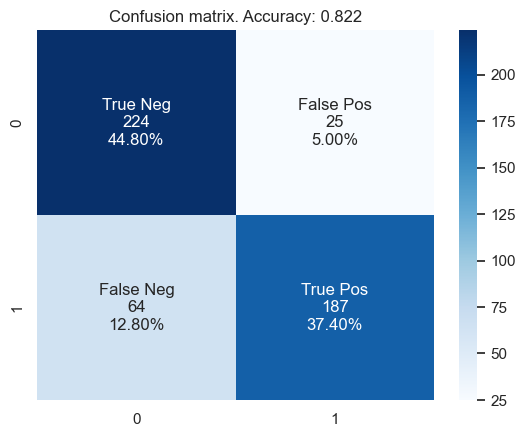

In [12]:
performance(model, model_embedding(X_test[:500]), y_test[:500])